In [94]:
import cv2
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt
import math
import xlwt 
import xlrd
from xlwt import Workbook 
%matplotlib inline

In [95]:
# Take the path of the image and return the Image
def Read(Image):
    Image = "inputs/" + Image
    Original = cv2.imread(Image)
    if Original is not None:
        Copy = Original.copy()
        Copy = cv2.cvtColor(Copy, cv2.COLOR_BGR2GRAY)
        return [Original,Copy]
    else:
        return None

In [96]:
def show(Image):
    plt.imshow(Image , cmap = "gray")
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

In [97]:
# Take an image and return the columns and rows of each circule
def GetCircules(Image , minR , maxR):
    Circles = cv2.HoughCircles(Image, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=minR , maxRadius=maxR)
    CirclesCopy = np.copy(Circles)
    if Circles is not None:
        Columns = Circles[0][:,0]
        Columns.sort()
        Rows = Circles[0][:,1]
        Rows.sort()
        return [CirclesCopy , Columns , Rows]
    else:
        return None

In [98]:
# This function return Array of the questions ans answers
def NumOfChoicesAndQuestion(Columns , Rows , Radius):
    NumberOfChoices=0
    AverageOfChoices = []
    NumberOfQuestions=0
    AverageOfQuestions = []
    
    Count = 0
    Sum = 0
    for i in range(len(Columns)-1):
        if abs(Columns[i]-Columns[i+1]) < int(Radius):      # each circule must be far from the another by 3 
            Count = Count+1
            Sum = Sum+Columns[i]
        else:
            if Count >= 2:                           # 3 Circules at least in one column
                AverageOfChoices.append(int(Sum/Count))
                NumberOfChoices = NumberOfChoices+1
            Sum = 0
            Count = 0
            
    if Count >= 2:  
        AverageOfChoices.append(int(Sum/Count))
        NumberOfChoices = NumberOfChoices+1
    Sum = 0
    Count = 0
                
        
    for i in range(len(Rows)-1):
        if abs(Rows[i]-Rows[i+1]) < int(Radius):            # each circule must be far from the another by 3
            Count = Count+1
            Sum = Sum+Rows[i]
        else:
            if Count >= 2:                         # 3 Circules at least in one rows
                AverageOfQuestions.append(int(Sum/Count))
                NumberOfQuestions = NumberOfQuestions+1
            Sum = 0
            Count = 0
       
    if Count >= 2:
        AverageOfQuestions.append(int(Sum/Count))
        NumberOfQuestions = NumberOfQuestions+1
    Sum = 0
    Count = 0
                
    return [NumberOfChoices , NumberOfQuestions , AverageOfChoices , AverageOfQuestions]

In [99]:
# This function take the column and the row of an answer and detect of which 
# question this answer belong and what is the answer (A,B,C,D,...)
def GetInformationOfAnswer(column, row , AverageOfChoices , AverageOfQuestions,Radius):
    Question = 0
    for i in range(len(AverageOfQuestions)):
        if abs(row - AverageOfQuestions[i]) < int(Radius):
            Question = i+1
            break


    Answer = 0
    for i in range(len(AverageOfChoices)):
        if abs(column - AverageOfChoices[i]) < int(Radius):
            Answer = i+1
            break
    return [Question , Answer]

In [100]:
#this function return only the row and the column of each answer
def GetOnlyAnswer(Image , minR , maxR):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
    img_erosion = cv2.morphologyEx(Image, cv2.MORPH_DILATE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_DILATE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_DILATE , kernel)

    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)
    img_erosion = cv2.morphologyEx(img_erosion, cv2.MORPH_ERODE , kernel)

    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    img_erosion = cv2.GaussianBlur(img_erosion,(5,5),cv2.BORDER_DEFAULT)
    
#     show(img_erosion)
    
    Circles = cv2.HoughCircles(img_erosion, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=minR , maxRadius=maxR)
    return [Circles, img_erosion]

In [101]:
# This function read the file of model answer
def ReadModelAnswer(File):
    File = "modelanswers/"+File
    f= open(File,"r")
    CorrectAnswer =f.readlines()
    for i in range(len(CorrectAnswer)):
        CorrectAnswer[i] = CorrectAnswer[i].strip(); 
    return CorrectAnswer


In [102]:
def BoundAnswers(Answer , Image):
    plt.rcParams["figure.figsize"] = (16,16)
    if Answer is not None: 
        for i in Answer[0,:]:
            cv2.circle(Image, (i[0],i[1]), i[2], (0,255,0), 2) 
    plt.imshow(Image)
    plt.show()

In [103]:
def ModifyLetterAndNumMap(AllAnswer ,NumOfRows ,NumOfChoices , NumOfQuestions):
    Letters = {1:"A" , 2:"B",3:"C" , 4:"D",5:"E" , 6:"F"}
    if NumOfRows == 1:
        for i in range(len(AllAnswer)):
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
            
    elif NumOfRows == 2:
        Segment = NumOfChoices/2
        for i in range(len(AllAnswer)):
            if AllAnswer[i][1] > Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+NumOfQuestions
                AllAnswer[i][1] = int(AllAnswer[i][1] - Segment)
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
            
    elif NumOfRows == 3:
        Segment = NumOfChoices/3
        for i in range(len(AllAnswer)):
            if AllAnswer[i][1] > 2*Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+(2*NumOfQuestions)
                AllAnswer[i][1] = int(AllAnswer[i][1] - (2*Segment))
                
            elif AllAnswer[i][1] > Segment:
                AllAnswer[i][0] = AllAnswer[i][0]+(NumOfQuestions)
                AllAnswer[i][1] = int(AllAnswer[i][1] - (Segment))
                
            AllAnswer[i][1] = Letters.get(AllAnswer[i][1])
    return AllAnswer

In [104]:
def RemoveDoublecate(AllAnswer):
    for i in range(len(AllAnswer)):
        for j in range(len(AllAnswer)):
            if (i != j):
                if(AllAnswer[i][0] == AllAnswer[j][0]):
                    AllAnswer[i][1] = None
                    AllAnswer[j][1] = None
    return AllAnswer

In [105]:
def CalculateGrade(AllAnswer , CorrectAnswer , QuestionsStates):
    Grade = 0
    for i in range(len(AllAnswer)):
        if CorrectAnswer[AllAnswer[i][0]-1] == AllAnswer[i][1]:
            QuestionsStates[AllAnswer[i][0]-1] = True
            Grade = Grade+1
        else:
            QuestionsStates[AllAnswer[i][0]-1] = False
            
    return [Grade,QuestionsStates]

In [148]:
def QuestionAndItsAnswer(OnlyAnswer ,AverageOfChoices , AverageOfQuestions,Radius):
    AllAnswer = []
    for i in OnlyAnswer[0]:
        answer = GetInformationOfAnswer( i[0],i[1], AverageOfChoices , AverageOfQuestions,Radius)
        if(answer[0] > 0 and answer[1] > 0):
            AllAnswer.append([answer[0] , answer[1]])
        
    return AllAnswer

In [107]:
def DetectRaduisAverage(Image , Original):
    AllCircles = GetOnlyAnswer(Image , 2 , 30)
    Circles = AllCircles[0]
#     Circles = cv2.HoughCircles(Image, cv2.HOUGH_GRADIENT, 1.2, 10 , param1=50 , param2=20 , minRadius=3 , maxRadius=12)
    if Circles is not None:
        Radius = Circles[0][:,2]
        SumRadius = Radius.sum()
        RadiusAverage = int(SumRadius/len(Radius))
#         BoundAnswers(Circles , Original)
        return [RadiusAverage,Circles]
    else:
        return None

In [108]:
def MaxFun(AllAnswer):
    ans = []
    for i in AllAnswer:
        ans.append(int(i[0]))

    return max(ans)

In [136]:
def Write(Grade , Name  , Message, QuestionsStates):
    
#     from openpyxl import Workbook
#     workbook = Workbook()
#     sheet = workbook.active
#     RR = []
#     RR.append("Name")
#     RR.append("Grade("+ str(len(QuestionsStates))+")")
#     RR.append("Message")
    
#     for i in range (1,61):
#         RR.append("Question"+str(i))
    
#     sheet.append(RR)
#     workbook.save(filename="output/Sheet.xlsx")
    
    
    
    
    from openpyxl import load_workbook
    workbook = load_workbook(filename="output/Sheet.xlsx")
    sheet = workbook.active
    R = []
    R.append(Name)
    R.append(Grade)
    R.append(Message)
    
    for i in range(len(QuestionsStates)):
        if QuestionsStates[i] == 1:
            R.append("True")
        else:
            R.append("False")
    
    sheet.append(R)
    workbook.save(filename="output/Sheet.xlsx")

In [127]:
def test(NumOfChoices , NumOfQuestion , AverageOfChoices , AverageOfQuestions,Circles,Columns ,Rows):
    print(NumOfChoices)
    print(NumOfQuestion)
    print(Rows)
    print(Columns)

In [166]:
# The main
def BubbleSheet(Exam , Model):
# Read the image (Original and copy)
    ReadImage = Read(Exam)
    if ReadImage is not None:
        Original = ReadImage[0]
        ForInitialAnswer = Original.copy()
        ForAllCircles = Original.copy()
        ForOnlyAnswer = Original.copy()
        Copy = ReadImage[1]

        # AverageRadius
        Initial = DetectRaduisAverage(Copy,ForInitialAnswer) ## Print the resulf of dilation and erosion and bound the answer 
        if Initial is not None:
            AverageRadius = Initial[0]
            ###
            InitialCircles = Initial[1]
            print(AverageRadius)                             ## Print the average radius
        else:
            Grade = 0
            Message = "No answer"
            print(Message)
            Write(None , None , Message)

        # TestDetection(Original,InitialCircles)
        ###
        if Initial is not None:
            # get the columns and rows for all circules
            Circles = GetCircules(Copy , AverageRadius-1 , AverageRadius+1)
            if Circles is not None:
                AllCircules = Circles[0]
                Columns = Circles[1]
                Rows = Circles[2]

        #         ####
        #         TestDetection(ForAllCircles , AllCircules)
        #         ####
                # get num of choices and question and the average of questions and answers
                NumOfChoices = NumOfChoicesAndQuestion(Columns , Rows,AverageRadius)[0]
                NumOfQuestions = NumOfChoicesAndQuestion(Columns , Rows,AverageRadius)[1]
                AverageOfChoices = NumOfChoicesAndQuestion(Columns , Rows,AverageRadius)[2]
                AverageOfQuestions = NumOfChoicesAndQuestion(Columns , Rows,AverageRadius)[3]

                test(NumOfChoices , NumOfQuestions , AverageOfChoices , AverageOfQuestions,Circles,Columns , Rows)

                # get only answers and draw them
                OnlyAnswer = GetOnlyAnswer(Copy,AverageRadius-1 , AverageRadius+1)[0]
                ImageAfterErosion = GetOnlyAnswer(Copy,AverageRadius-1 , AverageRadius+1)[1]

                # Read model answer
                CorrectAnswer = ReadModelAnswer(Model)

                if OnlyAnswer is not None:
                    # draw only answer
                    BoundAnswers(OnlyAnswer , ForOnlyAnswer)

                    # get the number of question and its answer
                    AllAnswer = QuestionAndItsAnswer(OnlyAnswer , AverageOfChoices,AverageOfQuestions,AverageRadius)
                    
                    # Modify the number of question and its answer
                    NumOfRows = math.ceil(len(CorrectAnswer)/NumOfQuestions)
            #         print(NumOfRows)                                            ## Print number of rows
                    AllAnswer = ModifyLetterAndNumMap(AllAnswer ,NumOfRows, NumOfChoices , NumOfQuestions)
                    print(AllAnswer)
                    AllAnswer = RemoveDoublecate(AllAnswer)
                    if MaxFun(AllAnswer) > len(CorrectAnswer):
                        Message = "Error in the system , error (0)"
                        Grade = -1
                    else:
                        # Calculate the grade
                        QuestionsStates = np.zeros(len(CorrectAnswer))
                        Grade = CalculateGrade(AllAnswer , CorrectAnswer , QuestionsStates)[0]
                        QuestionsStates = CalculateGrade(AllAnswer , CorrectAnswer , QuestionsStates)[1]
                        print(QuestionsStates)
                else:
                    Grade = -1
                    Message = "Error in the system , error (1)"
                    print(Message)

            else:
                Message = "Error in the system , error (2)"
                Grade = -1
                print(Message)



            # print The grade
            if Grade == -1:
                print(Message)
                Write(None , None , Message , [])

            elif Grade == 0:
                print("Num of correct answers = 0")
                print("Percentage = 0%")
                Write(Grade , None , None , [])
            else:
                percentage = (Grade/len(CorrectAnswer) * 100)
                percentage = (math.floor(percentage/.1))/10
                print("Num of correct answers = " + str(Grade))
                print("Percentage = " + str(percentage) + "%")
                Write(Grade , None , None , QuestionsStates)
    else:
        Message = "Can't load image"
        print(Message)
        Write(None , None , Message , [])

21
10
16
[ 322.2      323.40002  323.40002  324.6      324.6      325.80002
  327.       327.       327.       328.2      369.       370.2
  370.2      371.40002  371.40002  372.6      373.80002  373.80002
  375.       375.       414.6      414.6      415.80002  417.00003
  417.00003  419.40002  419.40002  420.6      420.6      420.6
  461.40002  461.40002  462.6      463.80002  465.00003  465.00003
  465.00003  466.2      467.40002  467.40002  508.2      509.40002
  509.40002  510.6      511.80002  513.       513.       513.
  514.2      514.2      553.80005  556.2      556.2      557.4
  558.60004  558.60004  558.60004  559.80005  561.       562.2
  601.80005  603.       603.       603.       604.2      605.4
  605.4      606.60004  607.80005  607.80005  648.60004  648.60004
  649.80005  651.       651.       652.2      653.4      653.4
  654.60004  654.60004  697.80005  697.80005  699.       699.
  699.       699.       700.2      700.2      701.4      702.60004
  744.60004  745.800

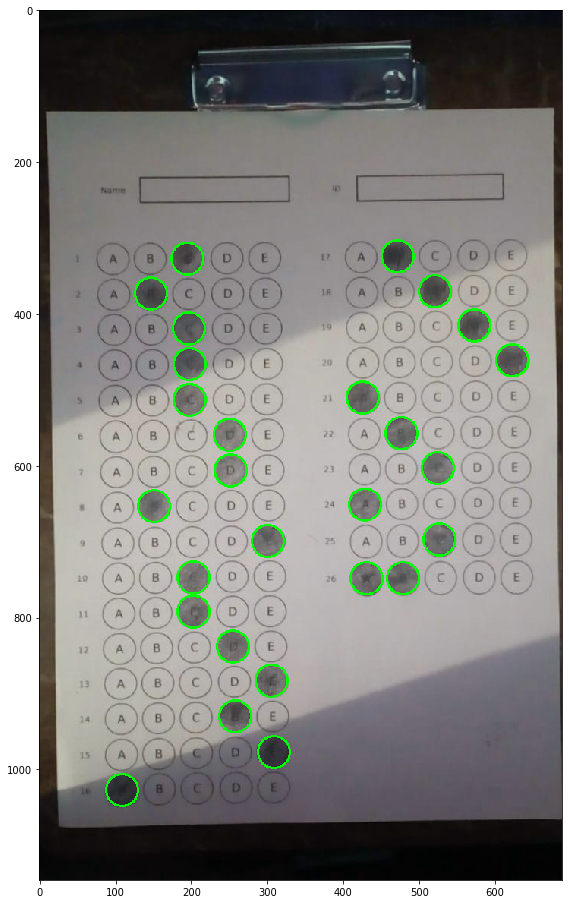

[[13, 'E'], [17, 'B'], [2, 'B'], [5, 'C'], [6, 'D'], [11, 'C'], [4, 'C'], [12, 'D'], [24, 'A'], [19, 'D'], [8, 'B'], [3, 'C'], [10, 'C'], [22, 'B'], [1, 'C'], [25, 'C'], [26, 'A'], [9, 'E'], [21, 'A'], [26, 'B'], [18, 'C'], [7, 'D'], [20, 'E'], [15, 'E'], [14, 'D'], [23, 'C'], [16, 'A']]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0.]
Num of correct answers = 12
Percentage = 46.1%


In [168]:
# BubbleSheet("Two0.png" , "Two0.txt")
# print("=================================================")
# BubbleSheet("Four0.png" , "Four0.txt")
# print("=================================================")
# BubbleSheet("Five0.png" , "Five0.txt")
# print("=================================================")
# BubbleSheet("TwoThree0.png" , "TwoThree0.txt")
# print("=================================================")
# BubbleSheet("FourOne0.png" , "FourOne0.txt")
# print("=================================================")
# BubbleSheet("CameraTwo0.jpeg" , "Two0.txt")

BubbleSheet("CameraFiveFar0.jpeg" , "Five0.txt")

# Some Notes

### 1)The function which detect circules must modify the raduis and i will make the min dis between two circles to be 10
### 2) I must get the average radius
### 3)I must handel if there is no circules
### 4) in the main if you find (###) it mean that this section is just test

In [ ]:
test = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
print(test)

In [ ]:
img = Read("input44.jpg")[1]
img = hist_eq(img)
plt.imshow(img)
plt.show()

In [26]:
test = [[4, 'D'], [4, 'C'], [12, 'D'], [29, 'A'], [10, 'D'], [23, 'B'], [11, 'C'], [6, 'C'], [8, 'C'], [21, 'A'], [7, 'B'], [30, 'C'], [3, 'B'], [32, 'B'], [1, 'A'], [14, 'C']]
test = RemoveDoublecate(test)
print(test)

[[4, None], [4, None], [12, 'D'], [29, 'A'], [10, 'D'], [23, 'B'], [11, 'C'], [6, 'C'], [8, 'C'], [21, 'A'], [7, 'B'], [30, 'C'], [3, 'B'], [32, 'B'], [1, 'A'], [14, 'C']]


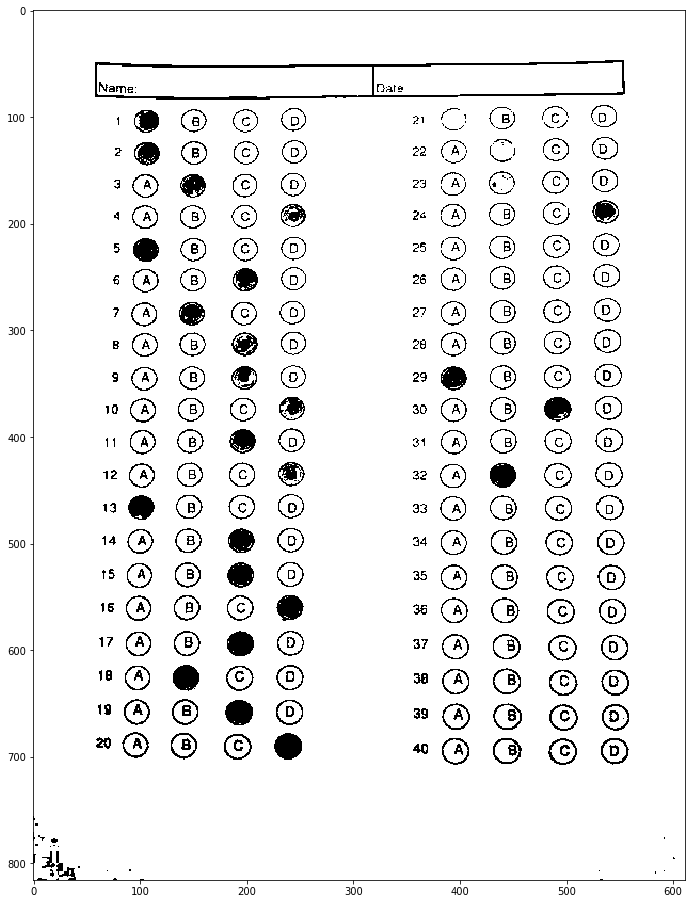

In [74]:
Image = Read("input55.jpg")[1]
# img = Image[int(Image.shape[0]/1.5) : Image.shape[0], :]
# img = cv2.equalizeHist(Image)

image = cv2.threshold(Image,130,255,cv2.THRESH_BINARY)[1]
return image
plt.imshow(image , cmap = "gray")
plt.show()